In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
# from transformers import pipeline, AutoTokenizer

sns.set(style="whitegrid")

In [19]:
df_price = pd.read_csv("data/bitcoin_2022_hourly.csv")

# Load and clean data

First we clean the data, put proper datetime and remove nans

In [2]:
df = pd.read_csv("bitcoin/submission.csv")

# Pre-processing
df = df.dropna(subset = "selftext")
df = df[ df["removed"] != 1]

# convert to datetime
df["datetime"] = pd.to_datetime(df["created"], unit="s")\

# Set 'datetime' column as the index
df.set_index('datetime', inplace=True, drop = True)

In [3]:
columns_to_keep = ["upvote_ratio", "score", "total_awards_received", "num_comments", "selftext", "author"]
df = df[columns_to_keep]

# Descriptive statistics

## num_comments

Look at how the post activity is done

Text(0.5, 1.0, 'Number of comments distribution')

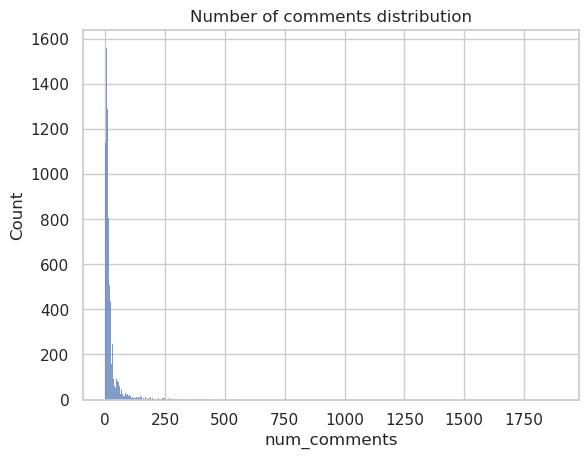

In [4]:
sns.histplot(df, x="num_comments")
plt.title("Number of comments distribution")

We see that most posts are unatractive; we assume that those posts have no influence on the btc price. Let's filter all posts below 100 comments.

<Axes: xlabel='num_comments', ylabel='Count'>

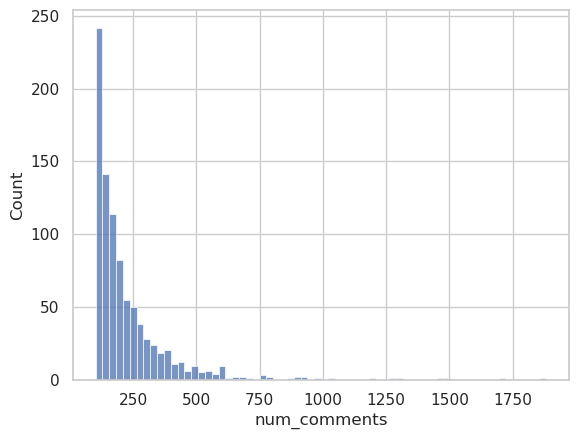

In [5]:
mask = df["num_comments"] > 100
sns.histplot(df[mask], x="num_comments")

## Authors diversity

Let's see if some authors are more influential than others

Text(0.5, 1.0, 'Top 10 authors')

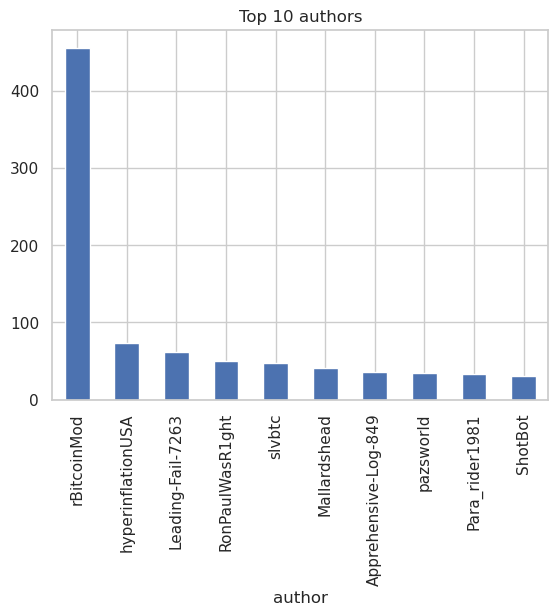

In [6]:
df["author"].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 authors")

We see that the first author is rBitcoinMod. This is a bot and the text it generates is not relevant as we don't have access to the comments. Let's filter him as well

Text(0.5, 1.0, 'Top 10 authors without rBitcoinMod')

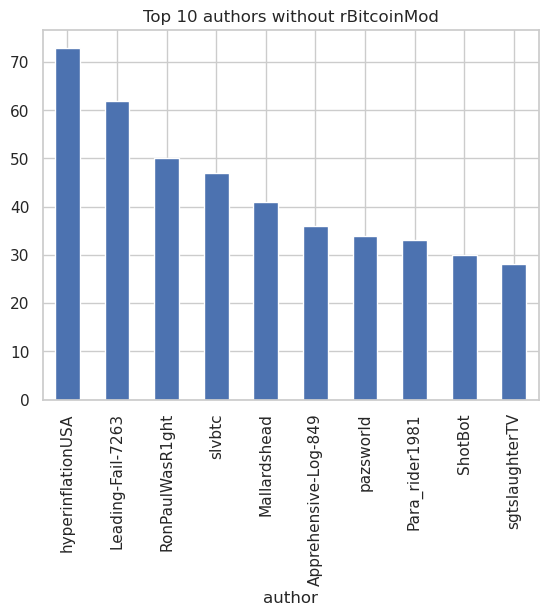

In [7]:
mask = df["author"] != "rBitcoinMod"
df[mask]["author"].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 authors without rBitcoinMod")

([], [])

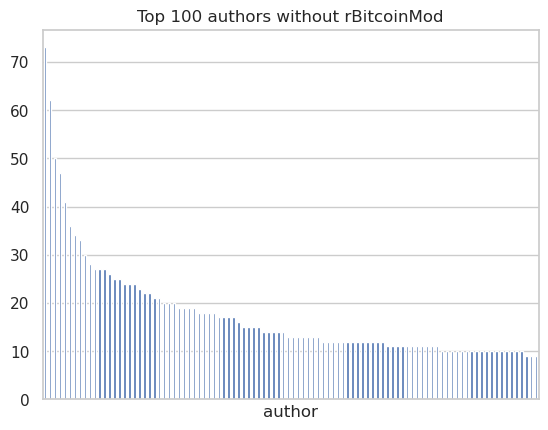

In [8]:
df[mask]["author"].value_counts().head(100).plot(kind='bar')
plt.title("Top 100 authors without rBitcoinMod")
# Remove x-axis ticks
plt.xticks([])

We have some very active authors and then they are more sparse.  

## Text samples

Let's dive at the content of our post

In [15]:
sample_text = df["selftext"].sample(1).values[0]
print(sample_text)

Hi everybody,

I was looking at my peer info in my GUI, all Peers addresses are onion addresses except one which points to my local address.  It looks something like this:

Peers      Address                                             Type               Network

50           \[down arrow\] [127.0.0.1:43724. ](https://127.0.0.1:43724)\[blank\]            Onion

&#x200B;

My hatch is that another user is downloading my copy of the blockchain cause inbound connection. Is that correct? I would just like to know what "50" is doing.

Thanks for your assistance...


## Time participation

See how link to bitcoin the number of comments are

<Axes: xlabel='date'>

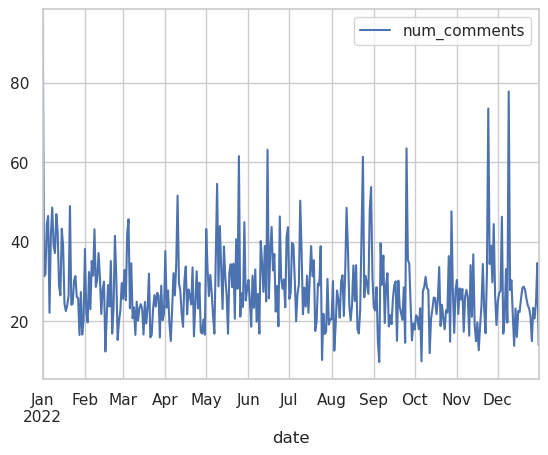

In [23]:
df["date"] = df.index.floor('d')
df_daily = df[["date","num_comments"]].groupby("date").mean()
df_daily.plot(y="num_comments")

<Axes: xlabel='date'>

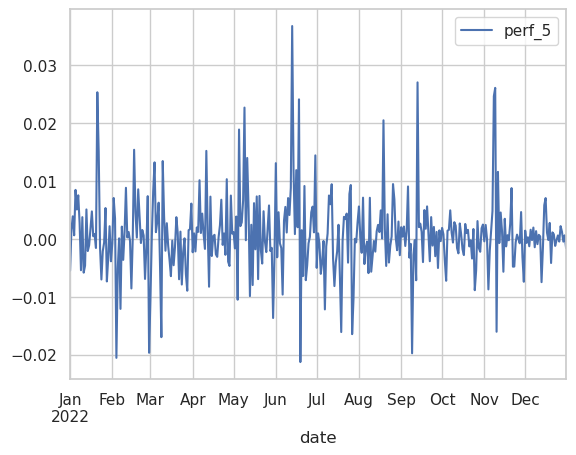

In [28]:
df_price["date"] = pd.to_datetime(df_price["datetime"]).dt.floor('d')
df_price_daily = df_price[["date", "open","perf_5"]].groupby("date").mean()
df_price_daily.plot(y="perf_5")

# Sentiment Analysis signal

## Preliminary signal

This signal is build using a RoBERta fine-tuned model used for reading financial news.

In [9]:
mask = (df["author"] != "rBitcoinMod") & (df["num_comments"] > 100)
df = df[mask]

In [10]:
MODEL = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=MODEL)

def remove_special_chars(text):
    return ''.join(e for e in text if e.isalnum() or e.isspace())

sentiments_label = []
sentiments_score = []
for txt in tqdm(df["selftext"].values):
    txt = remove_special_chars(txt)
    try:
        sentiment = sentiment_task(txt)
        sentiments_label.append(sentiment[0]["label"])
        sentiments_score.append(sentiment[0]["score"])
    except Exception as e:
        sentiments_label.append("N/A")
        sentiments_score.append(0)

100%|██████████| 723/723 [00:17<00:00, 41.40it/s]


In [11]:
df["sentiment_label"] = sentiments_label
df["sentiment_score"] = sentiments_score

lag = "24H"

mask_positive = df["sentiment_label"] == "positive"
mask_negative = df["sentiment_label"] == "negative"
mask_both = mask_positive | mask_negative

df["positive_score"] = 0
df.loc[mask_positive, 'positive_score'] = df[mask_positive]["sentiment_score"].values
df["negative_score"] = 0
df.loc[mask_negative, 'negative_score'] = df[mask_negative]["sentiment_score"].values


df["rolling_positive_score"] = df["positive_score"].rolling(lag).sum()
df["rolling_negative_score"] = df["negative_score"].rolling(lag).sum()

df["alpha"] = (df["rolling_positive_score"] - df["rolling_negative_score"]) / (df["rolling_positive_score"] + df["rolling_negative_score"] + 1e-4)

/tmp/ipykernel_426303/1938709055.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.99970275 0.91736192 0.99514306 0.83428782 0.99605727 0.99773872
 0.97375059 0.93658221 0.98233473 0.99815422 0.99886692 0.875853
 0.99968028 0.73171932 0.9575935  0.67608112 0.99915242 0.99662399
 0.74854213 0.93196648 0.97798663 0.90418744 0.6785984  0.99119723
 0.57825094 0.99879348 0.9986701  0.51935041 0.63535142 0.5026449
 0.99971706 0.84001416 0.99927133 0.99957067 0.62476796 0.99886703
 0.89931673 0.91915202 0.98671806 0.75527513 0.99771678 0.72642046
 0.99539977 0.99856901 0.93255788 0.99810022 0.97344798 0.99806589
 0.99441719 0.99412018 0.87118787 0.85302293 0.99833614 0.99801755
 0.98832524 0.99931955 0.9993912  0.97462553 0.58400172 0.98383051
 0.98572469 0.54950511 0.84054095 0.7720952  0.99015146 0.99735707
 0.99694175 0.94181776 0.99586099 0.99949133 0.84408629 0.55958205
 0.97109634 0.63509989 0.99848

<Axes: xlabel='sentiment_label'>

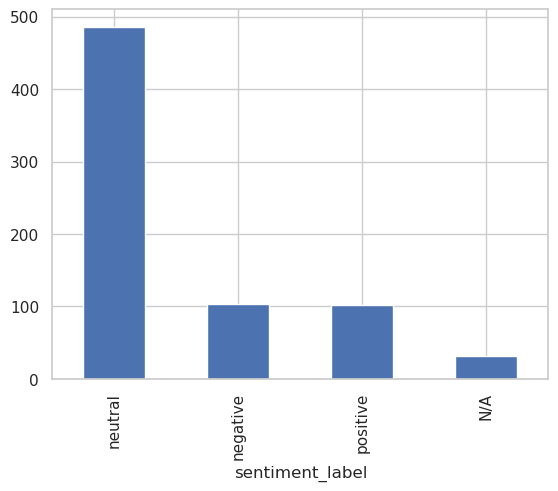

In [12]:
df["sentiment_label"].value_counts().plot(kind="bar")

<Axes: >

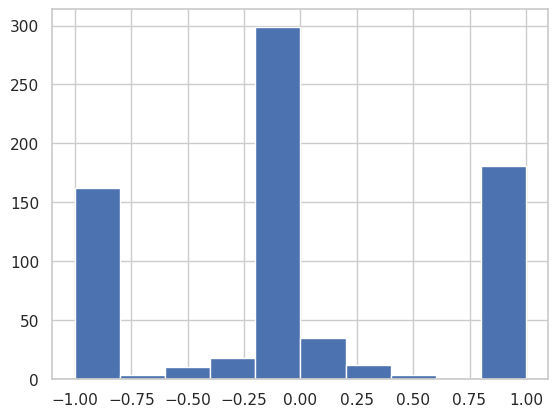

In [13]:
df["alpha"].hist()

# Price prediction

In [2]:
# checkpoint
df = pd.read_csv("bitcoin_2022/sentiment.csv")
df_price = pd.read_csv("bitcoin_2022/bitcoin_hourly.csv")

In [3]:
df_date_col_name = "created_utc"
df_price_date_col_name = "datetime"

df[df_date_col_name] = pd.to_datetime(df[df_date_col_name])
df_price[df_price_date_col_name] = pd.to_datetime(df_price[df_price_date_col_name])

In [4]:
# Sort df2 by timestamp to ensure binary search can be applied
df = df.sort_values(by=df_date_col_name)

# Method to find the closest timestamp in df2 that is less than or equal to the timestamp in df1
def find_closest_below(row, df1_date_col_name, df2_date_col_name):
    # Filter df2 to only include rows where the timestamp is less than or equal to the current row's timestamp in df1
    eligible_signals = df[df[df2_date_col_name] <= row[df1_date_col_name]]
    # If there are no eligible timestamps in df2, return NaN or some default value
    if eligible_signals.empty:
        return pd.NA
    else:
        # Return the signal of the closest timestamp
        return eligible_signals.iloc[-1]['alpha']

# Apply the function to df1
df_price['signal'] = df_price.apply(find_closest_below, df1_date_col_name=df_price_date_col_name, df2_date_col_name=df_date_col_name, axis=1)

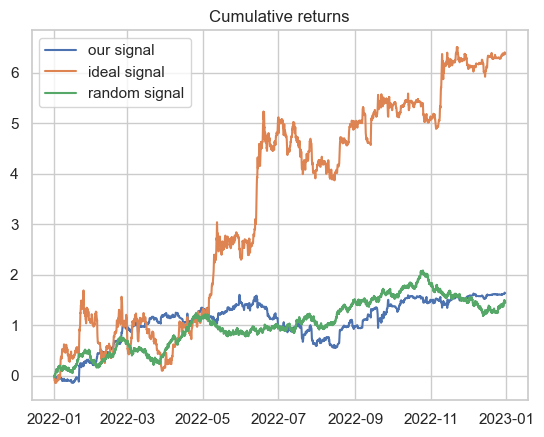

In [37]:
lag = 5
df_price["real"] = df_price[f"perf_{lag}"] * df_price["signal"]

# df_price["random_signal"] = np.random.uniform(low=-1, high=1, size=len(df_price))
df_price["random_signal"] = np.random.normal(0, 0.01, size=len(df_price))

plt.plot(df_price["datetime"], df_price["real"].cumsum(), label="our signal")
plt.plot(df_price["datetime"], df_price[f"perf_{lag}"].cumsum(), label="ideal signal") # TODO: should we square it?
plt.plot(df_price["datetime"], df_price["random_signal"].cumsum(), label="random signal")

plt.title("Cumulative returns")
plt.legend()

([], [])

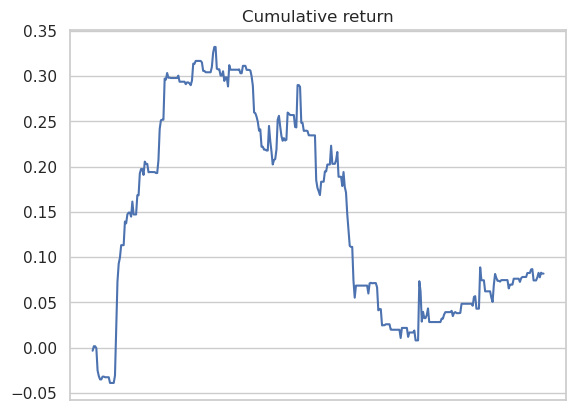

In [17]:
lag = 5
df_price["real"] = df_price[f"perf_{lag}"] * df_price["signal"]


plt.plot(df_price["datetime"],df_price["real"].cumsum())
plt.title("Cumulative return")
plt.xticks([])

#### Bitcoin vs. Sentiment signal

Text(0.5, 1.0, 'Bitcoin price 2022')

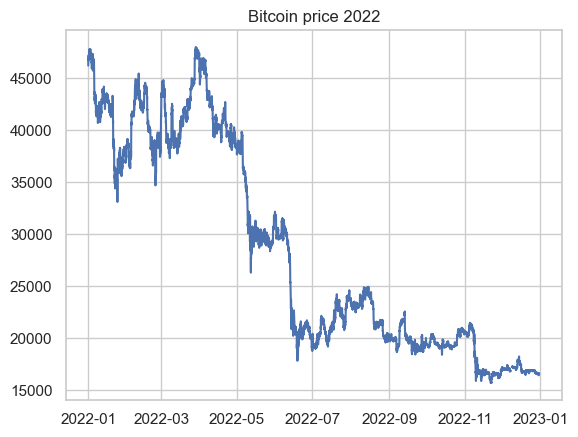

In [41]:
plt.plot(df_price["datetime"], df_price["open"])
plt.title("Bitcoin price 2022")

In [54]:
df.loc[df["author"].str.contains("bot"), "author"].unique()

array(['bot-repost-bot', 'solar_robot', 'Im_not_a_robot_8634', 'botolo',
       'Gregsbot', 'mrrobbottt', 'mulebotte', 'robotvoxy',
       'MonkeySoapRobotz', 'radarbot', 'DCARobot', 'toyrobotics',
       'TheRobotDr', 'therobotnipple'], dtype=object)

In [57]:
df["author"].nunique()

9819

In [47]:
df_price[["signal", "perf_5"]].isna().sum()

signal     1
perf_5    57
dtype: int64

In [49]:
df_price[["signal", "perf_5"]].dropna().corr()

,signal,perf_5
signal,1.000000,0.018753
perf_5,0.018753,1.000000


<Axes: >

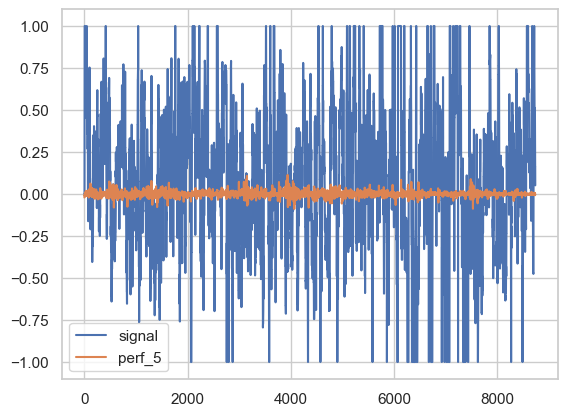

In [52]:
df_price[["signal", "perf_5"]].dropna().plot()

In [106]:
filter = df["selftext"].str.contains("http")
df.loc[filter, "selftext"].sample(1)

11071    [https://www.forbes.com/sites/markkantrowitz/2...
Name: selftext, dtype: object

In [107]:
df["selftext"].str.startswith("http|[http", regex=True).sum() / df.shape[0]

0.0